In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier 
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBClassifier, XGBRegressor

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, PowerTransformer

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

import scipy.stats as ss
from collections import Counter

import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score, classification_report

In [2]:
df_original = pd.read_csv('Train.csv')
df_original.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [3]:
df = df_original.copy()
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [4]:
bsDesc = []

for i in df.columns:
    bsDesc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        round((((df[i].isna().sum() )/ len(df)) * 100),2),
        df[i].nunique(),
        df[i].drop_duplicates().sample(2).values
    ])

pd.DataFrame(data = bsDesc,
            columns = [
                'Features',
                'DataType',
                'Null',
                'NullPercentage',
                'Unique',
                'Unique Sample'
            ])

,Features,DataType,Null,NullPercentage,Unique,Unique Sample
0,ID,int64,0,0.0,10999,"[10357, 6032]"
1,Warehouse_block,object,0,0.0,5,"[A, B]"
2,Mode_of_Shipment,object,0,0.0,3,"[Road, Flight]"
3,Customer_care_calls,int64,0,0.0,6,"[5, 2]"
4,Customer_rating,int64,0,0.0,5,"[1, 5]"
5,Cost_of_the_Product,int64,0,0.0,215,"[134, 205]"
6,Prior_purchases,int64,0,0.0,8,"[8, 4]"
7,Product_importance,object,0,0.0,3,"[high, low]"
8,Gender,object,0,0.0,2,"[F, M]"
9,Discount_offered,int64,0,0.0,65,"[38, 34]"


In [5]:
df_original.drop(columns='ID', inplace=True)
# df.drop(columns='ID', inplace=True)

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,10999.0,5500.000000,3175.282140,1.0,2750.5,5500.0,8249.5,10999.0
Customer_care_calls,10999.0,4.054459,1.141490,2.0,3.0,4.0,5.0,7.0
Customer_rating,10999.0,2.990545,1.413603,1.0,2.0,3.0,4.0,5.0
Cost_of_the_Product,10999.0,210.196836,48.063272,96.0,169.0,214.0,251.0,310.0
Prior_purchases,10999.0,3.567597,1.522860,2.0,3.0,3.0,4.0,10.0
Discount_offered,10999.0,13.373216,16.205527,1.0,4.0,7.0,10.0,65.0
Weight_in_gms,10999.0,3634.016729,1635.377251,1001.0,1839.5,4149.0,5050.0,7846.0
Reached.on.Time_Y.N,10999.0,0.596691,0.490584,0.0,0.0,1.0,1.0,1.0


In [7]:
df = pd.get_dummies(df, columns=['Warehouse_block'])
df = pd.get_dummies(df, columns=['Mode_of_Shipment'])
df = pd.get_dummies(df, columns=['Product_importance'])

In [8]:
df.Gender = df.Gender.apply(lambda x: 1 if x == 'F' else 0)
df

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium
0,1,4,2,177,3,1,44,1233,1,0,0,0,1,0,1,0,0,0,1,0
1,2,4,5,216,2,0,59,3088,1,0,0,0,0,1,1,0,0,0,1,0
2,3,2,2,183,4,0,48,3374,1,1,0,0,0,0,1,0,0,0,1,0
3,4,3,3,176,4,0,10,1177,1,0,1,0,0,0,1,0,0,0,0,1
4,5,2,2,184,3,1,46,2484,1,0,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10994,10995,4,1,252,5,1,1,1538,1,1,0,0,0,0,0,0,1,0,0,1
10995,10996,4,1,232,5,1,6,1247,0,0,1,0,0,0,0,0,1,0,0,1
10996,10997,5,4,242,5,1,4,1155,0,0,0,1,0,0,0,0,1,0,1,0
10997,10998,5,2,223,6,0,2,1210,0,0,0,0,0,1,0,0,1,0,0,1


In [9]:
# check balance
df['Reached.on.Time_Y.N'].value_counts(normalize=True)*100

1    59.669061
0    40.330939
Name: Reached.on.Time_Y.N, dtype: float64

In [10]:
# check balance
df['Reached.on.Time_Y.N'].value_counts()

1    6563
0    4436
Name: Reached.on.Time_Y.N, dtype: int64

In [19]:
def Eva_Matrix(Model, X, y_true):
    y_pred = Model.predict(X)
    acc = accuracy_score(y_true, y_pred)
    rec= recall_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return acc, rec, prec, roc, f1

In [12]:
X = df.drop(columns='Reached.on.Time_Y.N')
y = df['Reached.on.Time_Y.N']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = .20, random_state = 14)

In [14]:
X_train.shape

(8799, 19)

In [15]:
X_test.shape

(2200, 19)

In [16]:
LR_Base = LogisticRegression().fit(X_train, y_train)

In [17]:
KNN_Base = KNeighborsClassifier().fit(X_train, y_train)

In [18]:
SVM_Base = SVC().fit(X_train, y_train)

In [20]:
Ac_LR, Rec_LR, Pr_LR, Roc_LR, F1_LR = Eva_Matrix(LR_Base, X_test, y_test)
Ac_KNN, Rec_KNN, Pr_KNN, Roc_KNN, F1_KNN = Eva_Matrix(KNN_Base, X_test, y_test)
Ac_SVM, Rec_SVM, Pr_SVM, Roc_SVM, F1_SVM = Eva_Matrix(SVM_Base, X_test, y_test)

In [21]:
data = {
    "LogReg" : [Ac_LR, Rec_LR, Pr_LR, Roc_LR, F1_LR],
    "KNN" : [Ac_KNN, Rec_KNN, Pr_KNN, Roc_KNN, F1_KNN],
    "SVM" : [Ac_SVM, Rec_SVM, Pr_SVM, Roc_SVM, F1_SVM]
}

pd.DataFrame(data, index=['Accuracy', 'Recall', 'Precision', 'ROC_AUC', 'F1']).T.sort_values("Accuracy", ascending=False)

,Accuracy,Recall,Precision,ROC_AUC,F1
SVM,0.680000,0.476771,0.973561,0.728803,0.640082
KNN,0.657727,0.681645,0.727642,0.651984,0.703893
LogReg,0.642273,0.642803,0.726334,0.642145,0.682020


In [20]:
# improvement
rbs = RobustScaler()

In [21]:
X_train_sc = rbs.fit_transform(X_train)
X_test_sc = rbs.fit_transform(X_test)

In [22]:
skf = StratifiedKFold(n_splits=3)

In [23]:
LR_Tuned = LogisticRegression()

In [24]:
param_LR = {
    'C' : np.logspace(-3 , 3, 7),
    "penalty" : ['l1', 'l2', 'elasticnet']
}

In [25]:
GS_LR = GridSearchCV(LR_Tuned, param_LR, cv = skf, n_jobs=-1, verbose =1)

In [26]:
GS_LR.fit(X_train, y_train)

Fitting 3 folds for each of 21 candidates, totalling 63 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:    5.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2', 'elasticnet']},
             verbose=1)

In [27]:
GS_LR.best_score_

0.6296170019320377

In [22]:
poly_converter = PolynomialFeatures(degree=3, include_bias=False)
poly_features = poly_converter.fit_transform(X)

In [23]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(poly_features, y, stratify= y, test_size = 0.20, random_state = 14)

In [24]:
LR_Base_poli = LogisticRegression().fit(X_train_p, y_train_p)

In [25]:
KNN_Base_poli = KNeighborsClassifier().fit(X_train_p, y_train_p)

In [26]:
SVM_Base_poli = SVC().fit(X_train_p, y_train_p)

In [27]:
Ac_LR_poli, Rec_LR_poli, Pr_LR_poli, Roc_LR_poli, F1_LR_poli = Eva_Matrix(LR_Base_poli, X_test_p, y_test_p)
Ac_KNN_poli, Rec_KNN_poli, Pr_KNN_poli, Roc_KNN_poli, F1_KNN_poli = Eva_Matrix(KNN_Base_poli, X_test_p, y_test_p)
Ac_SVM_poli, Rec_SVM_poli, Pr_SVM_poli, Roc_SVM_poli, F1_SVM_poli = Eva_Matrix(SVM_Base_poli, X_test_p, y_test_p)

In [28]:
data = {
    "LogReg" : [Ac_LR_poli, Rec_LR_poli, Pr_LR_poli, Roc_LR_poli, F1_LR_poli],
    "KNN" : [Ac_KNN_poli, Rec_KNN_poli, Pr_KNN_poli, Roc_KNN_poli, F1_KNN_poli],
    "SVM" : [Ac_SVM_poli, Rec_SVM_poli, Pr_SVM_poli, Roc_SVM_poli, F1_SVM_poli]
}

pd.DataFrame(data, index=['Accuracy', 'Recall', 'Precision', 'ROC_AUC', 'F1']).T.sort_values("Accuracy", ascending=False)

,Accuracy,Recall,Precision,ROC_AUC,F1
SVM,0.677273,0.495050,0.932568,0.721031,0.646766
KNN,0.658182,0.672506,0.732780,0.654742,0.701350
LogReg,0.643636,0.668698,0.715566,0.637618,0.691339


In [35]:
# try scaling
sc = RobustScaler()

In [36]:
df.head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium
0,4,2,177,3,1,44,1233,1,0,0,0,1,0,1,0,0,0,1,0
1,4,5,216,2,0,59,3088,1,0,0,0,0,1,1,0,0,0,1,0
2,2,2,183,4,0,48,3374,1,1,0,0,0,0,1,0,0,0,1,0
3,3,3,176,4,0,10,1177,1,0,1,0,0,0,1,0,0,0,0,1
4,2,2,184,3,1,46,2484,1,0,0,1,0,0,1,0,0,0,0,1


In [37]:
num_col = df[['Customer_care_calls', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']]

In [38]:
sc_train = sc.fit_transform(num_col)

In [39]:
train_sc = pd.DataFrame(sc_train)

In [40]:
train_sc.head()

,0,1,2,3,4
0,0.0,-0.451220,0.0,6.166667,-0.908270
1,0.0,0.024390,-1.0,8.666667,-0.330478
2,-1.0,-0.378049,1.0,6.833333,-0.241395
3,-0.5,-0.463415,1.0,0.500000,-0.925713
4,-1.0,-0.365854,0.0,6.500000,-0.518611


In [41]:
df_scaled = pd.concat([df, train_sc], axis=1)

In [42]:
df_scaled.isna().sum()

Customer_care_calls          0
Customer_rating              0
Cost_of_the_Product          0
Prior_purchases              0
Gender                       0
Discount_offered             0
Weight_in_gms                0
Reached.on.Time_Y.N          0
Warehouse_block_A            0
Warehouse_block_B            0
Warehouse_block_C            0
Warehouse_block_D            0
Warehouse_block_F            0
Mode_of_Shipment_Flight      0
Mode_of_Shipment_Road        0
Mode_of_Shipment_Ship        0
Product_importance_high      0
Product_importance_low       0
Product_importance_medium    0
0                            0
1                            0
2                            0
3                            0
4                            0
dtype: int64

In [43]:
df_scaled.drop(columns=['Customer_care_calls', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms'], inplace=True)

In [44]:
X_scaled = df.drop(columns='Reached.on.Time_Y.N')
y_scaled = df['Reached.on.Time_Y.N']

In [45]:
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(X_scaled, y_scaled, stratify = y_scaled, test_size= .20, random_state = 14)

In [46]:
LR_Base_scaled = LogisticRegression().fit(X_train_sc, y_train_sc)

In [47]:
KNN_Base_scaled = KNeighborsClassifier().fit(X_train_sc, y_train_sc)

In [48]:
SVM_Base_scaled = SVC().fit(X_train_sc, y_train_sc)

In [49]:
Ac_LR_scaled, Rec_LR_scaled, Pr_LR_scaled, Roc_LR_scaled, F1_LR_scaled = Eva_Matrix(LR_Base_scaled, X_test_sc, y_test_sc)
Ac_KNN_scaled, Rec_KNN_scaled, Pr_KNN_scaled, Roc_KNN_scaled, F1_KNN_scaled = Eva_Matrix(KNN_Base_scaled, X_test_sc, y_test_sc)
Ac_SVM_scaled, Rec_SVM_scaled, Pr_SVM_scaled, Roc_SVM_scaled, F1_SVM_scaled = Eva_Matrix(SVM_Base_scaled, X_test_sc, y_test_sc)

In [50]:
data = {
    "LogReg" : [Ac_LR_scaled, Rec_LR_scaled, Pr_LR_scaled, Roc_LR_scaled, F1_LR_scaled],
    "KNN" : [Ac_KNN_scaled, Rec_KNN_scaled, Pr_KNN_scaled, Roc_KNN_scaled, F1_KNN_scaled],
    "SVM" : [Ac_SVM_scaled, Rec_SVM_scaled, Pr_SVM_scaled, Roc_SVM_scaled, F1_SVM_scaled]
}

pd.DataFrame(data, index=['Accuracy', 'Recall', 'Precision', 'ROC_AUC', 'F1']).T.sort_values("Accuracy", ascending=False)

,Accuracy,Recall,Precision,ROC_AUC,F1
SVM,0.674091,0.690784,0.744663,0.670082,0.716713
KNN,0.659545,0.674791,0.733444,0.655885,0.702896
LogReg,0.634091,0.665651,0.704839,0.626512,0.684685


In [51]:
# coba oversampling base model

In [41]:
df_train = pd.concat([X_train, y_train], axis = 1)
not_acc = df_train[df_train['Reached.on.Time_Y.N'] == 0]
acc = df_train[df_train['Reached.on.Time_Y.N'] == 1]

acc_oversample = resample(not_acc, replace=True, n_samples = len(acc), random_state = 14)
df_os = pd.concat([acc, acc_oversample])


In [42]:
df_os['Reached.on.Time_Y.N'].value_counts()

1    4922
0    4922
Name: Reached.on.Time_Y.N, dtype: int64

In [43]:
X_train_os = df_os.drop(columns = ['Reached.on.Time_Y.N'])
y_train_os = df_os['Reached.on.Time_Y.N']

In [44]:
X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(X_train_os, y_train_os, stratify = y_train_os, test_size= .25, random_state = 14)

In [31]:
LR_Base_os = LogisticRegression().fit(X_train_os, y_train_os)

In [32]:
KNN_Base_os = KNeighborsClassifier().fit(X_train_os, y_train_os)

In [33]:
SVM_Base_os = SVC().fit(X_train_os, y_train_os)

In [65]:
Ac_LR_os, Rec_LR_os, Pr_LR_os, Roc_LR_os, F1_LR_os = Eva_Matrix(LR_Base_os, X_test_os, y_test_os)
Ac_KNN_os, Rec_KNN_os, Pr_KNN_os, Roc_KNN_os, F1_KNN_os = Eva_Matrix(KNN_Base_os, X_test_os, y_test_os)
Ac_SVM_os, Rec_SVM_os, Pr_SVM_os, Roc_SVM_os, F1_SVM_os = Eva_Matrix(SVM_Base_os, X_test_os, y_test_os)

In [66]:
data = {
    "LogReg" : [Ac_LR_os, Rec_LR_os, Pr_LR_os, Roc_LR_os, F1_LR_os],
    "KNN" : [Ac_KNN_os, Rec_KNN_os, Pr_KNN_os, Roc_KNN_os, F1_KNN_os],
    "SVM" : [Ac_SVM_os, Rec_SVM_os, Pr_SVM_os, Roc_SVM_os, F1_SVM_os]
}

pd.DataFrame(data, index=['Accuracy', 'Recall', 'Precision', 'ROC_AUC', 'F1']).T.sort_values("Accuracy", ascending=False)

,Accuracy,Recall,Precision,ROC_AUC,F1
KNN,0.711905,0.631429,0.752554,0.711905,0.686691
LogReg,0.673810,0.506667,0.761087,0.673810,0.608348
SVM,0.672857,0.597143,0.703704,0.672857,0.646059


In [67]:
Eva_Matrix(KNN_Base_os, X_train_os, y_train_os)

(0.8054761904761905,
 0.7176190476190476,
 0.8705950317735413,
 0.8054761904761905,
 0.7867397546332551)

In [ ]:
# next coba over sampling with poly and scaling

In [23]:
df.head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium
0,4,2,177,3,1,44,1233,1,0,0,0,1,0,1,0,0,0,1,0
1,4,5,216,2,0,59,3088,1,0,0,0,0,1,1,0,0,0,1,0
2,2,2,183,4,0,48,3374,1,1,0,0,0,0,1,0,0,0,1,0
3,3,3,176,4,0,10,1177,1,0,1,0,0,0,1,0,0,0,0,1
4,2,2,184,3,1,46,2484,1,0,0,1,0,0,1,0,0,0,0,1


In [11]:
def Eva_Matrix2(Model, X_train, y_train, X_test, y_test, name):
    y_pred_train = Model.predict(X_train)
    y_pred_test = Model.predict(X_test)
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    rec_train = recall_score(y_train, y_pred_train)
    rec_test = recall_score(y_test, y_pred_test)
    prec_train = precision_score(y_train, y_pred_train)
    prec_test = precision_score(y_test, y_pred_test)
        
    data = {
        f"Training {name}": [acc_train, rec_train, prec_train],
        f"Testing {name}": [acc_test, rec_test, prec_test]
    }
    
    df_eva = pd.DataFrame(data, index=['Accuracy', 'Recall', 'Precision'])
    return df_eva

In [37]:
eva_base_os = Eva_Matrix2(SVM_Base_os, X_train_os,  y_train_os, X_test_os, y_test_os, "Base OS")
eva_base_os

,Training Base OS,Testing Base OS
Accuracy,0.684167,0.672857
Recall,0.610952,0.597143
Precision,0.715760,0.703704


In [38]:
## hypertune svm

In [41]:
param_svc = {
    "C": np.logspace(-3, 3, 7),
    "gamma": np.arange(10, 1001, 10)
}

In [15]:
skf= StratifiedKFold(n_splits=3)
param_LR = {
    "C": np.logspace(-3, 3, 7),
    "penalty": ['l1', 'l2', 'elasticenet']
}

In [44]:
SVC_Tuned = GridSearchCV(SVC(), param_svc, cv=skf, n_jobs=-1, verbose=1).fit(X_train, y_train)

Fitting 3 folds for each of 700 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 34.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 55.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 81.0min
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed: 94.5min finished


In [45]:
SVC1 = SVC_Tuned.best_estimator_

In [46]:
eva_scv_tunned = Eva_Matrix2(SVC1, X_train,  y_train, X_test, y_test, "SVC Tunned")
eva_scv_tunned

,Training SVC Tunned,Testing SVC Tunned
Accuracy,0.596659,0.596818
Recall,1.000000,1.000000
Precision,0.596659,0.596818


In [47]:
# random forest

In [33]:
param_rf = {
    "max_depth": [None, 5, 25, 50],
    "min_samples_leaf": np.arange(1, 50, 1),
    "min_sample_split": np.arange(1, 100, 1),
}

In [35]:
param_rf2 =  {"n_estimators":np.arange(100, 2000),
             "criterion" : ['gini', 'entropy'],
             "max_depth": [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50], 
             "min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
             "min_samples_leaf":[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50], 
             "max_features" : ['auto', 'sqrt', 'log2']}

In [45]:
RF_Tuned = RandomizedSearchCV(RandomForestClassifier(), param_rf2, n_jobs=-1, cv=3, n_iter=50, verbose=1).fit(X_train_os, y_train_os)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  6.9min finished


In [46]:
RF1 = RF_Tuned.best_estimator_

In [47]:
eva_rf_tunned = Eva_Matrix2(RF1, X_train,  y_train, X_test, y_test, "RandFor Tunned")
eva_rf_tunned

,Training RandFor Tunned,Testing RandFor Tunned
Accuracy,0.770760,0.671636
Recall,0.637749,0.496648
Precision,0.966739,0.913677


In [ ]:
param_rf2 =  {"n_estimators":[100, 200, 300, 400],
             "max_depth": [None, 5, 10, 25], 
             "min_samples_leaf":[1, 2, 5, 10, 15], 
             "max_features" : ['auto', 0.3, 0.5, 0.8],
              "class_weight": [{0: .20, 1: 0.8}, {0:0.25, 1: 0.75}]
             }

In [ ]:
param_rf2 =  {"n_estimators":np.arange(100, 1000, 100),
             "max_depth": [None, 5, 10, 25, 30, 40, 50, 60, 80, 100], 
             "min_samples_leaf":[1, 2, 5, 10, 15], 
             "max_features" : ['auto', 0.3, 0.5, 0.8],
              "class_weight": [{0: .20, 1: 0.8}, {0:0.25, 1: 0.75}]
             }

In [49]:
RF_base = RandomForestClassifier()

In [50]:
RF_base.fit(X_train, y_train)

RandomForestClassifier()

In [51]:
y_base = RF_base.predict(X_test)

In [52]:
accuracy_score(y_test, y_base)

0.6596363636363637

In [53]:
RF_base.feature_importances_

array([0.05747612, 0.06300133, 0.16978521, 0.06579448, 0.02321926,
       0.21954036, 0.26889479, 0.01086452, 0.01280268, 0.0125648 ,
       0.0116076 , 0.01582829, 0.01079931, 0.01126988, 0.01398498,
       0.00695002, 0.01270149, 0.01291487])

In [56]:
pd.DataFrame(RF_base.feature_importances_, index = X_train.columns, columns = ['Feature Importances'])

,Feature Importances
Customer_care_calls,0.057476
Customer_rating,0.063001
Cost_of_the_Product,0.169785
Prior_purchases,0.065794
Gender,0.023219
Discount_offered,0.219540
Weight_in_gms,0.268895
Warehouse_block_A,0.010865
Warehouse_block_B,0.012803
Warehouse_block_C,0.012565


In [57]:
RF_base2 = RandomForestClassifier()

In [58]:
RF_base2.fit(X_train_os, y_train_os)

RandomForestClassifier()

In [59]:
y_base2 = RF_base2.predict(X_test_os)

In [60]:
accuracy_score(y_test_os, y_base2)

0.7720438845997561

In [61]:
rfos_base_os = Eva_Matrix2(RF_base2, X_train_os,  y_train_os, X_test_os, y_test_os, "rf Base OS")
rfos_base_os

,Training rf Base OS,Testing rf Base OS
Accuracy,1.0,0.772044
Recall,1.0,0.636881
Precision,1.0,0.873051


In [62]:
RF_base2.feature_importances_

array([0.05396863, 0.05981479, 0.15855073, 0.06324562, 0.02190937,
       0.25091534, 0.25756197, 0.0118    , 0.01141668, 0.01211725,
       0.01199156, 0.01500829, 0.01096212, 0.01127268, 0.01393241,
       0.00783474, 0.01413816, 0.01355966])

In [63]:
pd.DataFrame(RF_base2.feature_importances_, index = X_train.columns, columns = ['Feature Importances'])

,Feature Importances
Customer_care_calls,0.053969
Customer_rating,0.059815
Cost_of_the_Product,0.158551
Prior_purchases,0.063246
Gender,0.021909
Discount_offered,0.250915
Weight_in_gms,0.257562
Warehouse_block_A,0.011800
Warehouse_block_B,0.011417
Warehouse_block_C,0.012117


# RESTART WITH FENGINE

In [66]:
df_original.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [60]:
df.head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium
0,4,2,177,3,1,44,1233,1,0,0,0,1,0,1,0,0,0,1,0
1,4,5,216,2,0,59,3088,1,0,0,0,0,1,1,0,0,0,1,0
2,2,2,183,4,0,48,3374,1,1,0,0,0,0,1,0,0,0,1,0
3,3,3,176,4,0,10,1177,1,0,1,0,0,0,1,0,0,0,0,1
4,2,2,184,3,1,46,2484,1,0,0,1,0,0,1,0,0,0,0,1


In [65]:
df.Weight_in_gms.describe()

count    10999.000000
mean      3634.016729
std       1635.377251
min       1001.000000
25%       1839.500000
50%       4149.000000
75%       5050.000000
max       7846.000000
Name: Weight_in_gms, dtype: float64

In [20]:
df_mean_weight = (df[['Reached.on.Time_Y.N', 'Weight_in_gms']].groupby(['Reached.on.Time_Y.N']).mean())
df_mean_weight

,Weight_in_gms
Reached.on.Time_Y.N,
0,4168.668395
1,3272.640104


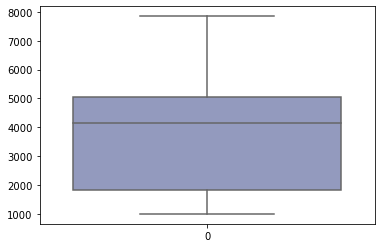

In [21]:
sns.boxplot(data=df['Weight_in_gms'], palette='BuPu')
plt.show()

In [10]:
q1 = df['Weight_in_gms'].describe()['25%']
q3 = df['Weight_in_gms'].describe()['75%']
q2 = df['Weight_in_gms'].describe()['50%']
iqr = q3 - q1
upperfence = q3 + (1.5 * iqr)
lowerfence = q1 - (1.5 * iqr)

In [11]:
# kelas 1 = berat >= q3
# kelas 2 = berat < q3 and berat >= q2
# kelas 3 = berat < q2 and berat >= q1
# kelas 4 = berat < q1

In [12]:
df['weight_status'] = df['Weight_in_gms'].apply(lambda x: 1 if x >= q3 else (2 if x >= q2 and x < q3 else(3 if x >=q1 and x <q2 else 4)) )

In [13]:
df.head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium,weight_status
0,4,2,177,3,1,44,1233,1,0,0,0,1,0,1,0,0,0,1,0,4
1,4,5,216,2,0,59,3088,1,0,0,0,0,1,1,0,0,0,1,0,3
2,2,2,183,4,0,48,3374,1,1,0,0,0,0,1,0,0,0,1,0,3
3,3,3,176,4,0,10,1177,1,0,1,0,0,0,1,0,0,0,0,1,4
4,2,2,184,3,1,46,2484,1,0,0,1,0,0,1,0,0,0,0,1,3


In [80]:
df.Discount_offered.describe()

count    10999.000000
mean        13.373216
std         16.205527
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         65.000000
Name: Discount_offered, dtype: float64

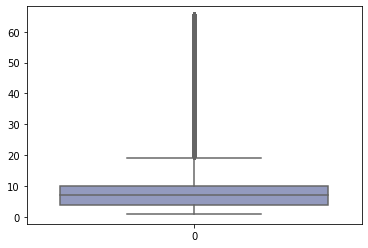

In [81]:
sns.boxplot(data=df['Discount_offered'], palette='BuPu')
plt.show()

In [ ]:
#kita drop aja discount_offered

In [14]:
df.drop(columns=['Weight_in_gms'], axis=1, inplace=True)
df.head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Gender,Discount_offered,Reached.on.Time_Y.N,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium,weight_status
0,4,2,177,3,1,44,1,0,0,0,1,0,1,0,0,0,1,0,4
1,4,5,216,2,0,59,1,0,0,0,0,1,1,0,0,0,1,0,3
2,2,2,183,4,0,48,1,1,0,0,0,0,1,0,0,0,1,0,3
3,3,3,176,4,0,10,1,0,1,0,0,0,1,0,0,0,0,1,4
4,2,2,184,3,1,46,1,0,0,1,0,0,1,0,0,0,0,1,3


In [15]:
X = df.drop(columns='Reached.on.Time_Y.N')
y = df['Reached.on.Time_Y.N']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = .20, random_state = 14)

In [67]:
KNN_Base = KNeighborsClassifier().fit(X_train, y_train)

In [68]:
RF_base = RandomForestClassifier().fit(X_train, y_train)

In [69]:
eva_knn = Eva_Matrix2(KNN_Base, X_train,  y_train, X_test, y_test, "KNN new")
eva_knn

,Training KNN new,Testing KNN new
Accuracy,0.768724,0.622727
Recall,0.775810,0.654227
Precision,0.825999,0.695547


In [70]:
eva_rf = Eva_Matrix2(RF_base, X_train,  y_train, X_test, y_test, "RF new")
eva_rf

,Training RF new,Testing RF new
Accuracy,0.999886,0.654545
Recall,1.000000,0.653465
Precision,0.999810,0.737747


In [71]:
pd.DataFrame(RF_base.feature_importances_, index = X_train.columns, columns = ['Feature Importances'])

,Feature Importances
Customer_care_calls,0.071312
Customer_rating,0.080158
Cost_of_the_Product,0.216442
Prior_purchases,0.073741
Gender,0.031195
Discount_offered,0.272859
Warehouse_block_A,0.014264
Warehouse_block_B,0.014213
Warehouse_block_C,0.014574
Warehouse_block_D,0.014771


In [17]:
poly_converter = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly_converter.fit_transform(X)

In [18]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(poly_features, y, stratify= y, test_size = 0.20, random_state = 14)

In [19]:
KNN_Base_poli = KNeighborsClassifier().fit(X_train_p, y_train_p)

In [20]:
RF_base_poli = RandomForestClassifier().fit(X_train_p, y_train_p)

In [21]:
eva_knn_poli = Eva_Matrix2(KNN_Base_poli, X_train_p,  y_train_p, X_test_p, y_test_p, "KNN new")
eva_knn_poli

,Training KNN new,Testing KNN new
Accuracy,0.762359,0.621364
Recall,0.769143,0.648896
Precision,0.821232,0.696078


In [22]:
eva_rf_poli = Eva_Matrix2(RF_base_poli, X_train_p,  y_train_p, X_test_p, y_test_p, "RF new")
eva_rf_poli

,Training RF new,Testing RF new
Accuracy,0.999886,0.638182
Recall,0.999810,0.632140
Precision,1.000000,0.726159


In [78]:
df_train = pd.concat([X_train, y_train], axis = 1)
not_acc = df_train[df_train['Reached.on.Time_Y.N'] == 0]
acc = df_train[df_train['Reached.on.Time_Y.N'] == 1]

acc_oversample = resample(not_acc, replace=True, n_samples = len(acc), random_state = 14)
df_os = pd.concat([acc, acc_oversample])

In [79]:
X_train_os = df_os.drop(columns = ['Reached.on.Time_Y.N'])
y_train_os = df_os['Reached.on.Time_Y.N']

In [80]:
X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(X_train_os, y_train_os, stratify = y_train_os, test_size= .20, random_state = 14)

In [81]:
KNN_Base_os = KNeighborsClassifier().fit(X_train_os, y_train_os)

In [82]:
SVC_base_os = SVC().fit(X_train_os, y_train_os)

In [83]:
eva_knn_os = Eva_Matrix2(KNN_Base_os, X_train_os,  y_train_os, X_test_os, y_test_os, "KNN new")
eva_knn_os

,Training KNN new,Testing KNN new
Accuracy,0.795476,0.703333
Recall,0.699286,0.600000
Precision,0.865861,0.756303


In [84]:
eva_svc_os = Eva_Matrix2(SVC_base_os, X_train_os,  y_train_os, X_test_os, y_test_os, "SVC new")
eva_svc_os

,Training SVC new,Testing SVC new
Accuracy,0.686667,0.685714
Recall,0.373333,0.371429
Precision,1.000000,1.000000


In [85]:
df.head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Gender,Discount_offered,Reached.on.Time_Y.N,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium,weight_status
0,4,2,177,3,1,44,1,0,0,0,1,0,1,0,0,0,1,0,4
1,4,5,216,2,0,59,1,0,0,0,0,1,1,0,0,0,1,0,3
2,2,2,183,4,0,48,1,1,0,0,0,0,1,0,0,0,1,0,3
3,3,3,176,4,0,10,1,0,1,0,0,0,1,0,0,0,0,1,4
4,2,2,184,3,1,46,1,0,0,1,0,0,1,0,0,0,0,1,3


In [23]:
rbs = RobustScaler()
num_col = df[['Customer_care_calls', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered']]

In [24]:
robust = RobustScaler().fit_transform(num_col)
data_rbs = pd.DataFrame(robust)
df_rbs = df.copy()
df_rbs.drop(columns=['Customer_care_calls', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered'], inplace=True)
df_robust = pd.concat([df_rbs, data_rbs], axis = 1)
df_robust.head()

,Customer_rating,Gender,Reached.on.Time_Y.N,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium,weight_status,0,1,2,3
0,2,1,1,0,0,0,1,0,1,0,0,0,1,0,4,0.0,-0.451220,0.0,6.166667
1,5,0,1,0,0,0,0,1,1,0,0,0,1,0,3,0.0,0.024390,-1.0,8.666667
2,2,0,1,1,0,0,0,0,1,0,0,0,1,0,3,-1.0,-0.378049,1.0,6.833333
3,3,0,1,0,1,0,0,0,1,0,0,0,0,1,4,-0.5,-0.463415,1.0,0.500000
4,2,1,1,0,0,1,0,0,1,0,0,0,0,1,3,-1.0,-0.365854,0.0,6.500000


In [88]:
df_robust.isna().sum()

Customer_rating              0
Gender                       0
Reached.on.Time_Y.N          0
Warehouse_block_A            0
Warehouse_block_B            0
Warehouse_block_C            0
Warehouse_block_D            0
Warehouse_block_F            0
Mode_of_Shipment_Flight      0
Mode_of_Shipment_Road        0
Mode_of_Shipment_Ship        0
Product_importance_high      0
Product_importance_low       0
Product_importance_medium    0
weight_status                0
0                            0
1                            0
2                            0
3                            0
dtype: int64

In [25]:
X_sc = df_robust.drop(columns='Reached.on.Time_Y.N')
y_sc = df_robust['Reached.on.Time_Y.N']

In [26]:
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(X_sc, y_sc, stratify = y_sc, test_size= .20, random_state=14) 

In [27]:
SVC_sc = SVC().fit(X_train_sc, y_train_sc)
KNN_sc = KNeighborsClassifier().fit(X_train_sc, y_train_sc)

In [28]:
eva_svc_sc = Eva_Matrix2(SVC_sc, X_train_sc,  y_train_sc, X_test_sc, y_test_sc, "svc new")
eva_svc_sc

,Training svc new,Testing svc new
Accuracy,0.682919,0.659545
Recall,0.520381,0.489718
Precision,0.909454,0.890582


In [29]:
eva_knn_sc = Eva_Matrix2(KNN_sc, X_train_sc,  y_train_sc, X_test_sc, y_test_sc, "svc new")
eva_knn_sc

,Training svc new,Testing svc new
Accuracy,0.766223,0.632273
Recall,0.774095,0.648896
Precision,0.823506,0.710000


In [100]:
# poli scaling

In [101]:
df_robust.head()

,Customer_rating,Gender,Reached.on.Time_Y.N,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium,weight_status,0,1,2,3
0,2,1,1,0,0,0,1,0,1,0,0,0,1,0,4,0.0,-0.451220,0.0,6.166667
1,5,0,1,0,0,0,0,1,1,0,0,0,1,0,3,0.0,0.024390,-1.0,8.666667
2,2,0,1,1,0,0,0,0,1,0,0,0,1,0,3,-1.0,-0.378049,1.0,6.833333
3,3,0,1,0,1,0,0,0,1,0,0,0,0,1,4,-0.5,-0.463415,1.0,0.500000
4,2,1,1,0,0,1,0,0,1,0,0,0,0,1,3,-1.0,-0.365854,0.0,6.500000


In [30]:
poly_converter = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly_converter.fit_transform(X_sc)

In [31]:
X_train_psc, X_test_psc, y_train_psc, y_test_psc = train_test_split(poly_features, y_sc, stratify= y_sc, test_size = 0.25, random_state = 14)

In [32]:
SVC_psc = SVC().fit(X_train_psc, y_train_psc)
KNN_psc = KNeighborsClassifier().fit(X_train_psc, y_train_psc)

In [33]:
eva_svc_psc = Eva_Matrix2(SVC_psc, X_train_psc,  y_train_psc, X_test_psc, y_test_psc, "svc new")
eva_svc_psc

,Training svc new,Testing svc new
Accuracy,0.682143,0.663636
Recall,0.519911,0.496648
Precision,0.908091,0.891685


In [34]:
eva_knn_psc = Eva_Matrix2(KNN_psc, X_train_psc,  y_train_psc, X_test_psc, y_test_psc, "knn new")
eva_knn_psc

,Training knn new,Testing knn new
Accuracy,0.767972,0.633091
Recall,0.771028,0.654479
Precision,0.828241,0.708443


In [35]:
param_svc = {
    "C": [1,2,3,4,5,6,7,8,9,10],
    "gamma": np.arange(10, 101, 10)
}

In [36]:
skf= StratifiedKFold(n_splits=3)
param_LR = {
    "C": [1,2,3,4,5,6,7,8,9,10],
    "penalty": ['l1', 'l2', 'elasticenet']
}

In [37]:
SVC_Tuned = GridSearchCV(SVC(), param_svc, cv=skf, n_jobs=-1, verbose=1).fit(X_train_psc, y_train_psc)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 35.8min finished


In [38]:
eva_svc_psc_t = Eva_Matrix2(SVC_Tuned, X_train_psc,  y_train_psc, X_test_psc, y_test_psc, "svc new")
eva_svc_psc_t

,Training svc new,Testing svc new
Accuracy,0.999515,0.596727
Recall,1.000000,0.998172
Precision,0.999188,0.596939


In [39]:
df_original

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10994,10995,A,Ship,4,1,252,5,medium,F,1,1538,1
10995,10996,B,Ship,4,1,232,5,medium,F,6,1247,0
10996,10997,C,Ship,5,4,242,5,low,F,4,1155,0
10997,10998,F,Ship,5,2,223,6,medium,M,2,1210,0


In [12]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [177]:
num_columns = ['Cost_of_the_Product', 'Prior_purchases', 'Weight_in_gms', 'Discount_offered', 'Customer_care_calls'] # 
 
cat_columns = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Customer_rating', 'Gender'] # 

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', RobustScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
#     ('power', PowerTransformer(method='yeo-johnson'))
])

categoric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, num_columns),
    ('categorical', categoric_pipeline, cat_columns)
])

pipe_SVM = Pipeline([
    ("prep", preprocessor),
    ("algo", SVC(probability=True))
])

pipe_KNN = Pipeline([
    ("prep", preprocessor),
    ("algo", KNeighborsClassifier())
])

pipe_RF = Pipeline([
    ("prep", preprocessor),
    ("algo", RandomForestClassifier())
])

In [178]:
X = df_original.drop(columns='Reached.on.Time_Y.N')
y = df_original['Reached.on.Time_Y.N']

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = .20, random_state = 14)

In [180]:
pipe_SVM.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False))]),
                                                  ['Cost_of_the_Product',
                                                   'Prior_purchases',
                                                   'Weight_in_gms',
                                                   'Discount_offered',
                                                   'Customer_care_calls']),
                                                 ('categorical',
                                              

In [181]:
pipe_KNN.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False))]),
                                                  ['Cost_of_the_Product',
                                                   'Prior_purchases',
                                                   'Weight_in_gms',
                                                   'Discount_offered',
                                                   'Customer_care_calls']),
                                                 ('categorical',
                                              

In [182]:
pipe_RF.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False))]),
                                                  ['Cost_of_the_Product',
                                                   'Prior_purchases',
                                                   'Weight_in_gms',
                                                   'Discount_offered',
                                                   'Customer_care_calls']),
                                                 ('categorical',
                                              

In [183]:
eva_svm_pipe = Eva_Matrix2(pipe_SVM, X_train,  y_train, X_test, y_test, "svm new")
eva_svm_pipe

,Training svm new,Testing svm new
Accuracy,0.662234,0.675455
Recall,0.669333,0.667936
Precision,0.739789,0.759307


In [184]:
eva_knn_pipe = Eva_Matrix2(pipe_KNN, X_train,  y_train, X_test, y_test, "knn new")
eva_knn_pipe

,Training knn new,Testing knn new
Accuracy,0.781907,0.647727
Recall,0.790667,0.662605
Precision,0.835043,0.723794


In [185]:
eva_rf_pipe = Eva_Matrix2(pipe_RF, X_train,  y_train, X_test, y_test, "rf new")
eva_rf_pipe

,Training rf new,Testing rf new
Accuracy,1.0,0.659091
Recall,1.0,0.651181
Precision,1.0,0.745423


In [128]:
param_KNN = {
    "prep__numeric__poly__degree" : [2, 3, 4, 5],
    "algo__n_neighbors" : np.arange(1, 51, 2),
    "algo__p" : [1, 2],
    'algo__weights' : ['uniform', 'distance']
}

In [131]:
param_svm = {
    "prep__numeric__poly__degree" : [2, 3, 4, 5],
    "algo__C" : np.arange(1, 20, 0.5),
    "algo__gamma" : np.arange(1, 20, 0.5),
    'algo__class_weight' : [{0 : .4, 1 : .6}, {0 : .6, 1 : .4}, "balanced", {0 : .3, 1 : .7}]
}

In [133]:
param_rf = {
    "algo__n_estimators":np.arange(100, 2000),
    "algo__max_depth": [None, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    "algo__min_samples_leaf": np.arange(1, 80, 4),
    "algo__max_features": ['auto', 'sqrt', 'log2']
}

In [134]:
skf = StratifiedKFold(n_splits=3, random_state=14)

In [137]:
SVC_R = RandomizedSearchCV(pipe_SVM, param_svm, cv = skf, scoring = 'accuracy', n_jobs = -1, verbose=1)

In [138]:
SVC_R.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 14.2min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=14, shuffle=False),
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('poly',
                                                                                                PolynomialFeatures(degree=3,
                                                                                                                   include_bias=False))]),
                                                                               ['Cost_of_the_Product',
                                                                                '

In [140]:
SVC_Tunned = SVC_R.best_estimator_

In [141]:
eva_svm_tuned = Eva_Matrix2(SVC_Tunned, X_train,  y_train, X_test, y_test, "svm new")
eva_svm_tuned

,Training svm new,Testing svm new
Accuracy,1.0,0.596818
Recall,1.0,1.000000
Precision,1.0,0.596818


In [143]:
RF_R = RandomizedSearchCV(pipe_RF, param_rf, cv = skf, scoring = 'accuracy', n_iter=50, n_jobs = -1, verbose=1)

In [144]:
RF_R.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 20.0min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=14, shuffle=False),
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('poly',
                                                                                                PolynomialFeatures(degree=3,
                                                                                                                   include_bias=False))]),
                                                                               ['Cost_of_the_Product',
                                                                                '

In [145]:
RF_Tuned = RF_R.best_estimator_

In [146]:
eva_rf_tuned = Eva_Matrix2(RF_Tuned, X_train,  y_train, X_test, y_test, "svm new")
eva_rf_tuned

,Training svm new,Testing svm new
Accuracy,0.691215,0.672273
Recall,0.531429,0.501904
Precision,0.915655,0.907713


In [3]:
df1 = df_original.copy()

In [161]:
df1.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,D,Flight,4,2,177,3,low,F,44,1233,1
1,F,Flight,4,5,216,2,low,M,59,3088,1
2,A,Flight,2,2,183,4,low,M,48,3374,1
3,B,Flight,3,3,176,4,medium,M,10,1177,1
4,C,Flight,2,2,184,3,medium,F,46,2484,1


In [162]:
df1.Warehouse_block.unique()

array(['D', 'F', 'A', 'B', 'C'], dtype=object)

In [163]:
df1['Warehouse_block'] = df1['Warehouse_block'].map({'A' : 1, 
                                                     'B' : 2,
                                                     'C' : 3,
                                                     'D' : 4,
                                                     'F' : 5
                                                    })

In [164]:
df1.Mode_of_Shipment.unique()

array(['Flight', 'Ship', 'Road'], dtype=object)

In [165]:
df1['Mode_of_Shipment'] = df1['Mode_of_Shipment'].map({'Flight' : 1, 
                                                     'Ship' : 2,
                                                     'Road' : 3
                                                    })

In [166]:
df1.Product_importance.unique()

array(['low', 'medium', 'high'], dtype=object)

In [167]:
df1['Product_importance'] = df1['Product_importance'].map({'low' : 1, 'medium' : 2,'high' : 3})

In [168]:
df1['Gender'] = df1['Gender'].map({'F' : 1, 
                                   'M' : 0
                                  })

In [169]:
df1.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,4,1,4,2,177,3,1,1,44,1233,1
1,5,1,4,5,216,2,1,0,59,3088,1
2,1,1,2,2,183,4,1,0,48,3374,1
3,2,1,3,3,176,4,2,0,10,1177,1
4,3,1,2,2,184,3,2,1,46,2484,1


In [170]:
X = df1.drop(columns='Reached.on.Time_Y.N')
y = df1['Reached.on.Time_Y.N']

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = .20, random_state = 14)

In [172]:
RF_Base = RandomForestClassifier().fit(X_train, y_train)

In [173]:
eva_rf_base = Eva_Matrix2(RF_Base, X_train,  y_train, X_test, y_test, "svm new")
eva_rf_base

,Training svm new,Testing svm new
Accuracy,1.0,0.652727
Recall,1.0,0.600152
Precision,1.0,0.767283


In [174]:
RF_Base.feature_importances_

array([0.05549287, 0.03364166, 0.05686847, 0.05874955, 0.17566465,
       0.05910828, 0.03362453, 0.02376338, 0.21941656, 0.28367007])

In [176]:
pd.DataFrame(RF_Base.feature_importances_, index = X_train.columns, columns = ['Feature Importances'])

,Feature Importances
Warehouse_block,0.055493
Mode_of_Shipment,0.033642
Customer_care_calls,0.056868
Customer_rating,0.058750
Cost_of_the_Product,0.175665
Prior_purchases,0.059108
Product_importance,0.033625
Gender,0.023763
Discount_offered,0.219417
Weight_in_gms,0.283670


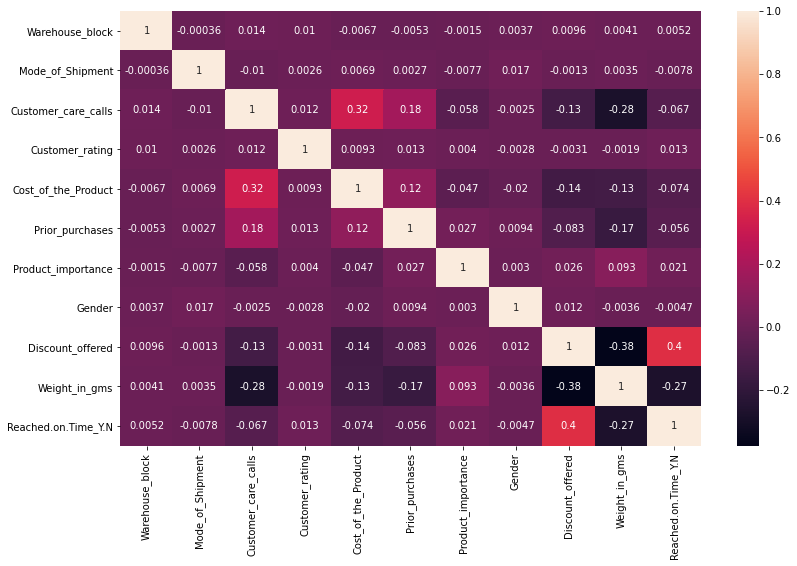

In [188]:
plt.figure(figsize=(13,8))
sns.heatmap(df1.corr(), annot= True)
plt.show()

In [4]:
num_columns = ['Cost_of_the_Product', 'Prior_purchases', 'Weight_in_gms', 'Discount_offered' ] #'Customer_care_calls' 
 
# cat_columns = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Customer_rating', 'Gender'] # 

# Cost_of_the_Product: 15.63
# Prior_purchases: 10.7
# Weight_in_gms: 66.26
# Discount_offered: 46.34

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', RobustScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
#     ('power', PowerTransformer(method='yeo-johnson'))
])

# categoric_pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('encoder', OneHotEncoder())
# ])

preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, num_columns),
#     ('categorical', categoric_pipeline, cat_columns)
])

pipe_SVM = Pipeline([
    ("prep", preprocessor),
    ("algo", SVC(probability=True))
])

pipe_KNN = Pipeline([
    ("prep", preprocessor),
    ("algo", KNeighborsClassifier())
])

pipe_RF = Pipeline([
    ("prep", preprocessor),
    ("algo", RandomForestClassifier())
])

In [5]:
X = df1.drop(columns='Reached.on.Time_Y.N')
y = df1['Reached.on.Time_Y.N']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = .20, random_state = 14)

In [7]:
pipe_SVM.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False))]),
                                                  ['Cost_of_the_Product',
                                                   'Prior_purchases',
                                                   'Weight_in_gms',
                                                   'Discount_offered'])])),
                ('algo', SVC(probability=True))])

In [8]:
pipe_KNN.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False))]),
                                                  ['Cost_of_the_Product',
                                                   'Prior_purchases',
                                                   'Weight_in_gms',
                                                   'Discount_offered'])])),
                ('algo', KNeighborsClassifier())])

In [9]:
pipe_RF.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False))]),
                                                  ['Cost_of_the_Product',
                                                   'Prior_purchases',
                                                   'Weight_in_gms',
                                                   'Discount_offered'])])),
                ('algo', RandomForestClassifier())])

In [12]:
eva_knn_pipe = Eva_Matrix2(pipe_KNN, X_train,  y_train, X_test, y_test, "knn new")
eva_knn_pipe

,Training knn new,Testing knn new
Accuracy,0.782134,0.647727
Recall,0.790476,0.661843
Precision,0.835514,0.724167


In [13]:
eva_svm_pipe = Eva_Matrix2(pipe_SVM, X_train,  y_train, X_test, y_test, "svm new")
eva_svm_pipe

,Training svm new,Testing svm new
Accuracy,0.662234,0.675909
Recall,0.669143,0.667936
Precision,0.739890,0.759965


In [14]:
eva_rf_pipe = Eva_Matrix2(pipe_RF, X_train,  y_train, X_test, y_test, "rf new")
eva_rf_pipe

,Training rf new,Testing rf new
Accuracy,0.999886,0.641818
Recall,1.000000,0.651942
Precision,0.999810,0.721146


In [202]:
def cramers(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1) * (r-2)) / (n-1))
    rcorr = r - ((r-1) ** 2)/(n-1)
    kcorr = k - ((k-1) ** 2)/(n-1)
    return np.sqrt(phi2corr/ min((kcorr -1), (rcorr-1)))

In [211]:
y_col = ['Cost_of_the_Product', 'Prior_purchases', 'Weight_in_gms', 'Discount_offered', 'Customer_care_calls' , 'Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Customer_rating', 'Gender']
for i in range(len(y_col)):
    cor_res = cramers(df_original['Reached.on.Time_Y.N'], df_original[y_col[i]])
    
    print('{}: {}'.format(y_col[i], round((cor_res * 100), 2)))

Cost_of_the_Product: 15.63
Prior_purchases: 10.7
Weight_in_gms: 66.26
Discount_offered: 46.34
Customer_care_calls: 7.02
Warehouse_block: 1.0
Mode_of_Shipment: 0.82
Product_importance: 3.33
Customer_rating: 1.71
Gender: 0.45


In [ ]:
# Cost_of_the_Product: 15.63
# Prior_purchases: 10.7
# Weight_in_gms: 66.26
# Discount_offered: 46.34